# **Applied AI in Biomedicine - Final Assignment**
## PAC/PVC classification from ECG signals
***
* Alberto Rota: *Person Code: 10615751 - Student Number: 964662 - [alberto2.rota@mail.polimi.it](mailto:alberto2.rota@mail.polimi.it)*  
* Gabriele Santicchi: *Person Code: 10579046 - Student Number: 969088 - [gabriele.santicchi@mail.polimi.it](mailto:gabriele.santicchi@mail.polimi.it)*
***

In [269]:
import os
import numpy as np, os, sys, joblib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import seaborn as sns
import tarfile
import math
import random
import sklearn
import timeit
import json
import warnings
import random

import scipy
from scipy.io import loadmat
from random import randint

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers


from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import preprocessing 

SEED = 69
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("Using Tensorflow version",tf.__version__)
print("RNG seed:", SEED)

color = {
    "lead": "#073b4c",
    "N": "#06d6a0",
    "S": "#ef476f",
    "V": "#ffd166",
    "X": "#118ab2"
}

Using Tensorflow version 2.6.0
RNG seed: 69


In [2]:
dataset_dir = "C:\\Users\\alber\\Desktop\\Files\\Università\\V ANNO ACCADEMICO\\AI in Biomedicine\\Workshop\\PAC-PVC-Beat-Classifier-for-ECGs\\data"

## Patient class definition

In [271]:
class Patient:
    def __init__(self,init_dict):
        self.path=init_dict['path']
        self.fs=init_dict['fs']
        self.id=init_dict['id']
        self.rpeaks=init_dict['rpeaks']
        self.peaklabels=init_dict['peaklabels']
        self.samples=init_dict['samples']
        self.time=np.arange(0,self.samples/self.fs,1/self.fs)
        self.lead1=init_dict['lead1']
        self.lead2=init_dict['lead2']
        if self.fs != 128:
            f1 = scipy.interpolate.interp1d(self.time,self.lead1)
            f2 = scipy.interpolate.interp1d(self.time,self.lead2)
            self.time=np.arange(0,self.samples/self.fs,1/self.fs)
            self.fs = 128.0
            self.lead1 = f1(self.time)
            self.lead2 = f2(self.time)
        
        insideborders = np.logical_and(self.rpeaks>0, self.rpeaks<self.samples)
        
        if self.rpeaks.shape[0]-np.count_nonzero(insideborders)>0: 
            print(f"PATIENT {self.id}: Found {self.rpeaks.shape[0]-np.count_nonzero(insideborders)} samples out of bounds")
            self.rpeaks = self.rpeaks[insideborders]
            self.peaklabels = self.peaklabels[insideborders]
                                
    def info(self):
        print(">> ID:",self.id)
        print(" | Path:",self.path)
        print(" | fs:",self.fs)
        print(" | samples:",self.samples)
        print(" | lead1:",self.lead1)
        print(" | lead2:",self.lead2)
        print(" | rpeaks:",self.rpeaks)
        print(" | peaklabels:",self.peaklabels)
        
    def plot(self,windowstart=None,xrange=4000,splitleads=False):
        if windowstart is None: windowstart = randint(0,self.samples-xrange)
        
        if not splitleads: 
            plt.figure(figsize=(10,7))
            plt.subplot(2,1,1)
        if splitleads: plt.figure(figsize=(10,2.5))
        plt.plot(self.time,self.lead1,color=color['lead'])
        plt.scatter(self.rpeaks[self.peaklabels=='N']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='N']],
            color=color['N'],s=500,alpha=0.5,label="Normal")
        plt.scatter(self.rpeaks[self.peaklabels=='S']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='S']],
            color=color['S'],s=500,alpha=0.5,label="SopraVentricular")
        plt.scatter(self.rpeaks[self.peaklabels=='V']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='V']],
            color=color['V'],s=500,alpha=0.5,label="Ventricular")
        plt.grid(True)
        plt.xlim([windowstart/self.fs,(windowstart+xrange)/self.fs])
        plt.title(f"Patient #{self.id} - ECG lead 1")
        if splitleads: plt.xlabel("Time [seconds]")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        if splitleads: plt.show()
        
        if not splitleads: 
            plt.subplot(2,1,2)
        if splitleads: plt.figure(figsize=(10,2.5))
        plt.plot(self.time,self.lead2,color=color['lead'])
        plt.scatter(self.rpeaks[self.peaklabels=='N']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='N']],
            color=color['N'],s=500,alpha=0.5,label="Normal")
        plt.scatter(self.rpeaks[self.peaklabels=='S']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='S']],
            color=color['S'],s=500,alpha=0.5,label="SopraVentricular")
        plt.scatter(self.rpeaks[self.peaklabels=='V']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='V']],
            color=color['V'],s=500,alpha=0.5,label="Ventricular")
        plt.grid(True)
        plt.xlim([windowstart/self.fs,(windowstart+xrange)/self.fs])
        plt.title(f"Patient #{self.id} - ECG lead 2")
        plt.xlabel("Time [seconds]")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

    def split_RRR(self,borders=0.05, fixed_length=False):
        border_samples = round(borders*(self.rpeaks[0]))
        
        wl1 = [self.lead1[0:(self.rpeaks[0]-border_samples)]]
        wl2 = [self.lead1[0:(self.rpeaks[0]-border_samples)]]
        
        for p in range(1,self.rpeaks.shape[0]-1):
            border_samples = round(borders*(self.rpeaks[p+1]-self.rpeaks[p-1]))
            window = self.lead1[(self.rpeaks[p-1]+border_samples):(self.rpeaks[p+1]-border_samples)]
            wl1.append(window)
            window = self.lead2[(self.rpeaks[p-1]+border_samples):(self.rpeaks[p+1]-border_samples)]
            wl2.append(window)
        
        border_samples = round(borders*(self.rpeaks[0]))
        wl1.append(self.lead1[self.rpeaks[-1]:self.samples])
        wl2.append(self.lead1[self.rpeaks[-1]:self.samples])
        
        if fixed_length != False:
            r1,r2 = [],[]
            for i,_ in enumerate(wl1):
                if wl1[i].shape[0] >= fixed_length:
                    r1.append(
                        wl1[i][wl1[i].shape[0]//2-fixed_length//2:wl1[i].shape[0]//2+(fixed_length-fixed_length//2)]
                    )
                    r2.append(
                        wl2[i][wl2[i].shape[0]//2-fixed_length//2:wl2[i].shape[0]//2+(fixed_length-fixed_length//2)]
                    )
                elif wl1[i].shape[0] < fixed_length:
                    padleft  = (fixed_length-wl1[i].shape[0])//2
                    padright = fixed_length-padleft-wl1[i].shape[0]
                    r1.append(
                        np.pad(wl1[i], (padleft,padright), mode='edge')
                    )
                    r2.append(
                        np.pad(wl2[i], (padleft,padright), mode='edge')
                    )
                elif wl1[i].shape[0] == fixed_length:
                    r1.append(
                        wl1[i][-fixed_length:]
                    )
                    r2.append(
                        wl2[i][-fixed_length:]
                    )
            wl1,wl2 = r1,r2
        return wl1,wl2
        
    def split_windows(self, width=100):
        wl1,wl2=[],[]
        
        right = width//2
        left = width-right
        LEN = self.lead1.shape[0]

        for i in range(self.rpeaks.shape[0]):
            peak = self.rpeaks[i]
            
            if peak-left >= 0 and peak+right < LEN: 
                window = self.lead1[(peak-left):(peak+right)]
            elif peak-left < 0:
                window = np.pad(self.lead1[0:(peak+right)],(abs(width-(peak+right)),0))
                
            elif peak+right >= LEN:
                window = np.pad(self.lead1[(peak-left):LEN],(0,abs(width-(LEN-(peak-left)))))
                
            wl1.append(window)
            
            if peak-left >= 0 and peak+right < LEN: 
                window = self.lead2[(peak-left):(peak+right)]
            elif peak-left < 0:
                window = np.pad(self.lead2[0:(peak+right)],(abs(width-(peak+right)),0))
                
            elif peak+right >= LEN:
                window = np.pad(self.lead2[(peak-left):LEN],(0,abs(width-(LEN-(peak-left)))))
            
            wl2.append(window)

        return wl1,wl2

## Data Loading

In [272]:
files = os.listdir(dataset_dir)
patient = []
correct,ncorrect=0,0
for f in range(0,len(files),3):
    try: 
        recs = loadmat(os.path.join("data",files[f]))
        ann = loadmat(os.path.join("data",files[f+1]))
        rp =loadmat(os.path.join("data",files[f+2]))
        patient_as_dict={
                'id':files[f].split(".")[0].split("_")[0],
                'path':os.path.join("data",files[f]),
                'fs':float(files[f].split(".")[0].split("_")[1]),
                'samples':recs['ecg'][:,0].shape[0],
                'lead1':recs['ecg'][:,0],
                'lead2':recs['ecg'][:,1],
                'rpeaks':rp['rpeaks'].T[0],
                'peaklabels':ann['labels'] 
        }
        patient.append(Patient(patient_as_dict))
        correct+=1
        
    except:
        ncorrect+=1
        
print(f"Loaded {correct} files correctly")
if ncorrect>0: print(f"!!!! Error in loading {ncorrect} files")
ptest = patient[9] # Test patient

PATIENT S005: Found 1 samples out of bounds
PATIENT S009: Found 1 samples out of bounds
Loaded 105 files correctly


### Examples of ECG signals

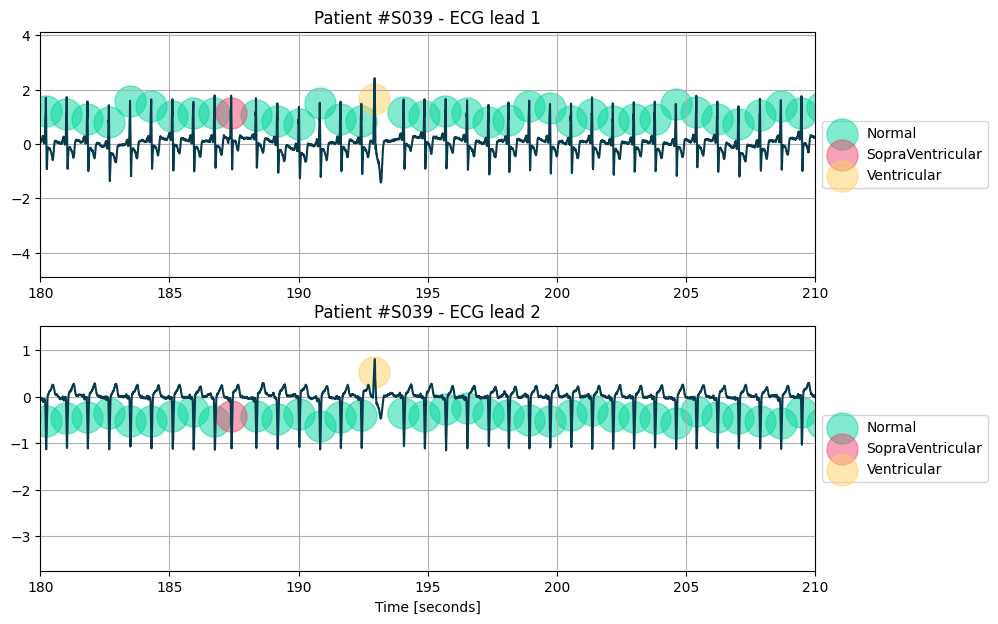

In [275]:
patient[38].plot(180*patient[38].fs,30*patient[38].fs) # 1 Sopraventricular, 1 Ventricular
# patient[13].plot() # Lots of Sopraventriculars
# patient[9].plot() # Lots of both Sopraventriculars and Ventriculars
# patient[0].plot(60000,5000) # Baseline wonder

## Window splitting

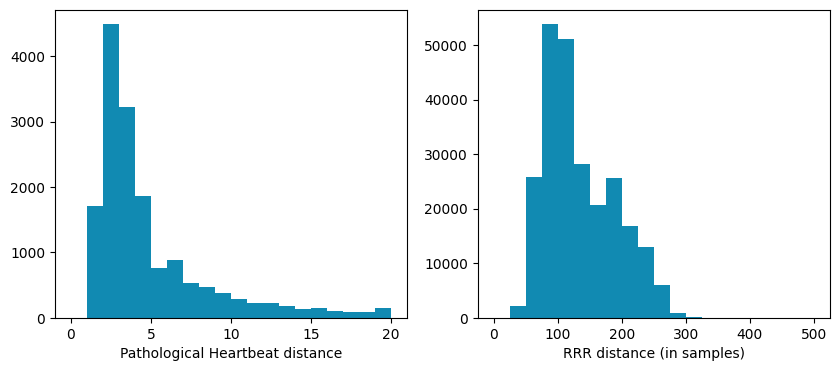

In [302]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

ints = []
wins = []
N_count = 0
S_count = 0
V_count = 0

for ptest in patient:
    nn = np.where(np.logical_or(ptest.peaklabels=='V',ptest.peaklabels=='S'))
    intervals = np.diff(nn)[0]
    wins.append(np.diff(ptest.rpeaks))
    ints.append(intervals)
    N_count+=np.count_nonzero(ptest.peaklabels=='N')
    S_count+=np.count_nonzero(ptest.peaklabels=='S')
    V_count+=np.count_nonzero(ptest.peaklabels=='V')
    
intervals = np.concatenate(ints,axis=0)
RRR = np.concatenate(wins,axis=0)
rng=[0,20]
plt.hist(intervals,bins=rng[-1],range=rng,color=color['X'])
# plt.xticks(range(rng[-1]))
plt.xlabel("Pathological Heartbeat distance")
# plt.grid(True)

plt.subplot(1,2,2)
plt.hist(RRR,color=color['X'], range=[0,500],bins=20)
plt.xlabel("RRR distance (in samples)")
# plt.xticks(range(rng[-1]))
# plt.title("Density of distance (in heartbeats) between adjacent pathological heartbeats")
# plt.grid(True)
plt.show()

Difference in splitting strategies:
* **`Split_RRR(fixed_length==False)`** keeps only the desired R-peak in the window --> INCONSISTENCY in window length

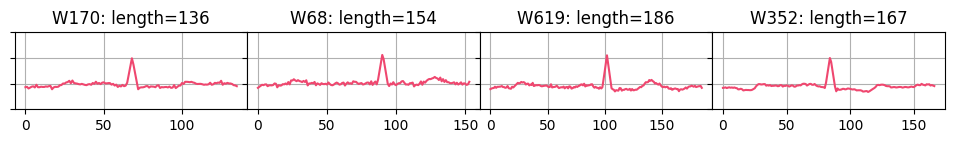

In [263]:

split1,_ = ptest.split_RRR(borders=0.05)
idxs = [randint(0,1000) for _ in range(4)]
plt.figure(figsize=(12,1))
for p,i in enumerate(idxs):
    plt.subplot(1,4,p+1)
    plt.plot(split1[i],color=color['S'])
    plt.title(f"W{i}: length={len(split1[i])}")        
    yt,_ = plt.yticks()
    plt.yticks(ticks=yt,labels=[])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.grid(True)
plt.show()

* **`Split_RRR(fixed_length==True)`** keeps only the desired R-peak in the window and pads/cuts to fix the window width --> CONSISTENCY in window length

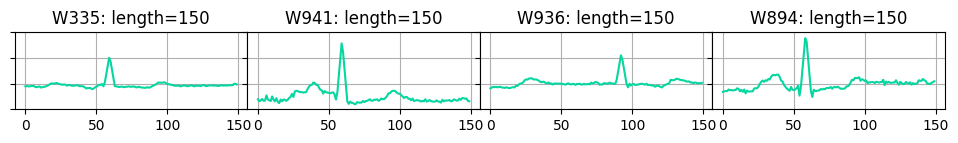

In [264]:

split1,_ = ptest.split_RRR(borders=0.05,fixed_length=150)
idxs = [randint(0,1000) for _ in range(4)]
plt.figure(figsize=(12,1))
for p,i in enumerate(idxs):
    plt.subplot(1,4,p+1)
    plt.plot(split1[i],color=color['N'])
    plt.title(f"W{i}: length={len(split1[i])}")        
    yt,_ = plt.yticks()
    plt.yticks(ticks=yt,labels=[])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.grid(True)
plt.show()

* **`split_windows(width=150)`** slices a fixed number of samples around each R-peak --> Multiple peaks may appear in the same window

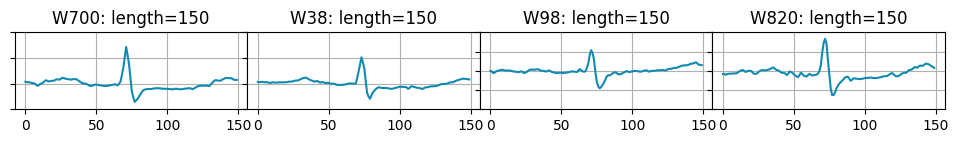

In [292]:

split1,_ = ptest.split_windows(150)
idxs = [randint(0,1000) for _ in range(4)]
plt.figure(figsize=(12,1))
for p,i in enumerate(idxs):
    plt.subplot(1,4,p+1)
    plt.plot(split1[i],color=color['X'])
    plt.title(f"W{i}: length={len(split1[i])}")        
    yt,_ = plt.yticks()
    plt.yticks(ticks=yt,labels=[])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.grid(True)
plt.show()

## Label encoding
* **N**: Normal
* **S**: Sopraventricular
* **V**: Ventricular
* **X**: A virtual label used to classify the first beats in the recording, on which there is no information about the past

In [268]:
categorical = {'X':np.array([1,0,0,0]),'N':np.array([0,1,0,0]),'S':np.array([0,0,1,0]),'V':np.array([0,0,0,1])}

In [308]:
print("CLASS WEIGHTING")
N_samples = N_count+V_count+S_count
CLASS_WEIGHT = {
    0:0,
    1:N_samples/(3*N_count),
    2:N_samples/(3*S_count),
    3:N_samples/(3*V_count),
}
CLASS_WEIGHT

CLASS WEIGHTING


{0: 0, 1: 0.3588977511420556, 2: 8.475873313213308, 3: 10.448321573658328}

## Building the Dataset

In [296]:
def build_dataset(patients, width=150):
    XtrainWins=[]
    XtrainPast=[]
    Ytrain=[]
    for i,p in enumerate(patients):
        split1,split2 = p.split_RRR(borders=0.05, fixed_length=width)
        # print(i)
        for i in range(len(split1)):
            XtrainWins.append(
                np.column_stack((split1[i],split2[i]))
            )
            Ytrain.append(
                categorical[p.peaklabels[i]]
            )
            if i>=2:
                XtrainPast.append(
                    np.array([categorical[p.peaklabels[i-2]],categorical[p.peaklabels[i-1]]])
                )
            elif i==1:
                XtrainPast.append(
                    np.array([categorical['X'],categorical[p.peaklabels[i-1]]])
                )
            else:
                XtrainPast.append(
                    np.array([categorical['X'],categorical['X']])
                )
                
    return (np.stack(XtrainWins,axis=0),np.stack(XtrainPast,axis=0)),np.stack(Ytrain,axis=0)

(XtrainW,XtrainP),Ytrain=build_dataset(patients,150)
print(f"INPUT WINDOW shape: {XtrainW.shape} as (WINDOW, TIME, LEAD)")
print(f"INPUT PAST shape: {XtrainP.shape} as (WINDOW, PAST, one-hot-LABEL)")
print(f"OUTPUT shape: {Ytrain.shape} as (WINDOW, one-hot-LABEL)")


INPUT WINDOW shape: (244334, 150, 2) as (WINDOW, TIME, LEAD)
INPUT PAST shape: (244334, 2, 4) as (WINDOW, PAST, one-hot-LABEL)
OUTPUT shape: (244334, 4) as (WINDOW, one-hot-LABEL)


### Train-Test-Validation Split

In [298]:
from sklearn.model_selection import train_test_split

XtrainW,XvalW,XtrainP,XvalP,Ytrain,Yval = train_test_split(
    XtrainW,XtrainP,Ytrain, test_size=0.3, shuffle=True, stratify=Ytrain)

XvalW,XtestW,XvalP,XtestP,Yval,Ytest = train_test_split(
    XvalW,XvalP,Yval, test_size=0.3, shuffle=True, stratify=Yval)

print(f"{len(XtrainW)} TRAINING samples: {XtrainW[0].shape}[Window] + {XtrainP[0].shape}[Past Labels] --> {Ytrain[0].shape}[Classification]")
print(f"{len(XvalW)} VALIDATION samples: {XvalW[0].shape}[Window] + {XvalP[0].shape}[Past Labels] --> {Yval[0].shape}[Classification]")
print(f"{len(XtestW)} TESTING samples: {XtestW[0].shape}[Window] + {XtestP[0].shape}[Past Labels] --> {Ytest[0].shape}[Classification]")

171033 TRAINING samples: (150, 2)[Window] + (2, 4)[Past Labels] --> (4,)[Classification]
51310 VALIDATION samples: (150, 2)[Window] + (2, 4)[Past Labels] --> (4,)[Classification]
21991 TESTING samples: (150, 2)[Window] + (2, 4)[Past Labels] --> (4,)[Classification]


# Building the Model

Model: "PAC_PVC_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputWin (InputLayer)           [(None, 150, 2)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 150, 128)     67072       InputWin[0][0]                   
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 128)          131584      lstm_2[0][0]                     
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128)          0           lstm_3[0][0]                     
_________________________________________________________________________________

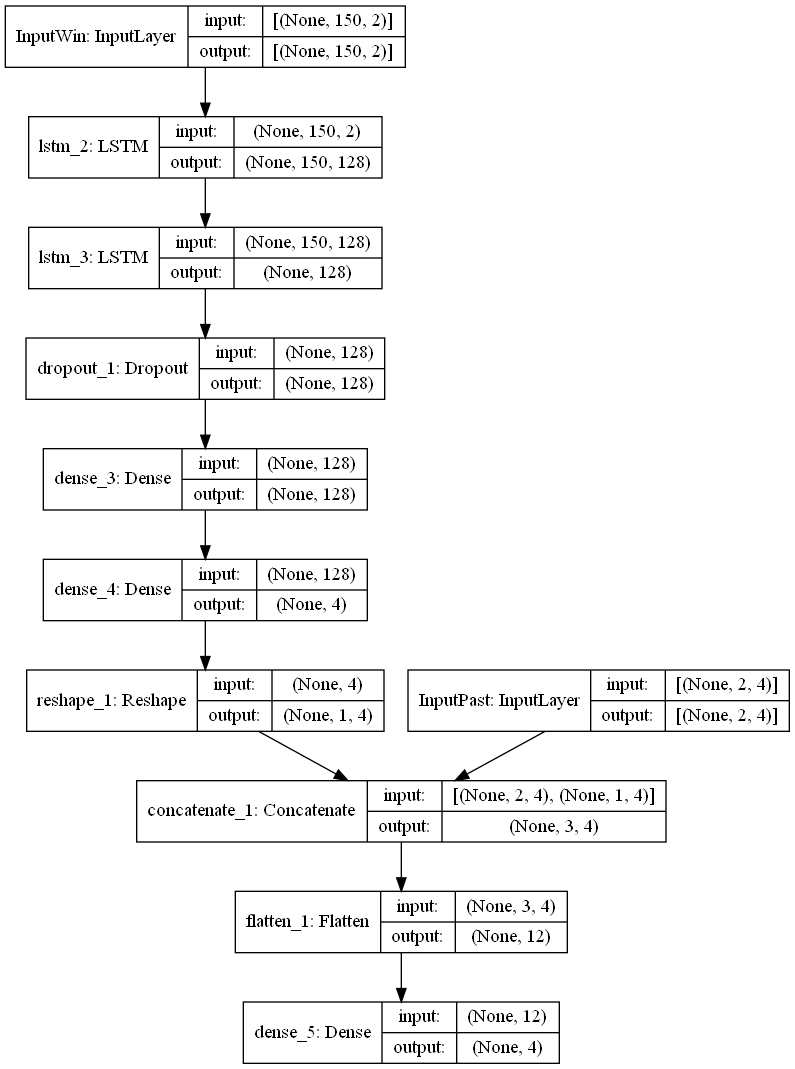

In [297]:
def build_model(inputwin_shape,inputpast_shape, classes):
    
    inputwin_layer = tfkl.Input(shape=inputwin_shape, name='InputWin')
    inputpast_layer = tfkl.Input(shape=inputpast_shape, name='InputPast')

    lstm = tfkl.LSTM(128, return_sequences=True)(inputwin_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=SEED)(lstm)

    classifier = tfkl.Dense(128, activation='relu')(dropout)
    x = tfkl.Dense(classes, activation='softmax')(classifier)
    
    x2 = tfkl.Reshape((1,4))(x)
    xc = tfkl.Concatenate(axis=1)([inputpast_layer,x2])
    x = tfkl.Flatten()(xc)
    output_layer = tfkl.Dense(classes,activation='softmax')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs=[inputwin_layer,inputpast_layer], outputs=output_layer, name='PAC_PVC_classifier')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model 

model = build_model(inputwin_shape=XtrainW[0].shape,inputpast_shape=XtrainP[0].shape, classes=4)
model.summary()
tfk.utils.plot_model(model,show_shapes=True)

# Training

In [310]:
BATCH_SIZE=512
EPOCHS=100

model.compile(
    loss = tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate= 1e-3),
    metrics = ['accuracy']
)

history = model.fit(
    x = [XtrainW,XtrainP],
    y = Ytrain,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHT,
    validation_data=([XvalW,XvalP],Yval)
)

Epoch 1/100
335/335 [==============================] - 1160s 3s/step - loss: 1.1985 - accuracy: 0.8721 - val_loss: 1.0709 - val_accuracy: 0.8612
Epoch 2/100
244/335 [====================>.........] - ETA: 4:58 - loss: 1.0846 - accuracy: 0.8619

KeyboardInterrupt: 

Preprocessing:
* numpy Interp1D per upsampling/downsampling
* Controllo NaN  e Outliers
* (Rescale su singola finestra)
* Cosa fare con finestre di different lenght?
Modelli: